In [1]:
import os
import librosa
import torch
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split

# Path to dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400

def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    return audio

def extract_features(file_path):
    """Extract mel spectrogram features"""
    audio = load_audio(file_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [2]:
# Audio augmentations
def add_noise(audio, noise_level=0.005):
    return audio + noise_level * np.random.randn(len(audio))

def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

def change_pitch(audio, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=random.uniform(-pitch_factor, pitch_factor))


def change_speed(audio, speed_factor_range=(0.9, 1.1)):
    speed = random.uniform(*speed_factor_range)
    return librosa.effects.time_stretch(audio, rate=speed)

def apply_audio_augmentations(audio, sr):
    if random.random() < 0.5:
        audio = add_noise(audio)
    if random.random() < 0.5:
        audio = time_shift(audio)
    if random.random() < 0.5:
        audio = change_pitch(audio, sr)
    if random.random() < 0.5:
        audio = change_speed(audio)
    return audio


In [3]:
def create_balanced_dataset(data_path):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    # Count files per class
    class_to_files = {cls: [] for cls in classes}
    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                class_to_files[label].append(file_path)

    # Determine minimum class count
    #min_class_count = min(len(files) for files in class_to_files.values())
    min_class_count = 750

    # Collect features with balanced sampling
    for label in classes:
        selected_files = class_to_files[label][:min_class_count]  # balance
        for file_path in selected_files:
            features = extract_features(file_path)
            X.append(features)
            y.append(label_map[label])
    
    return np.array(X), np.array(y), label_map

X, y, label_map = create_balanced_dataset(DATA_PATH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
import torch.nn as nn

# class AudioDataset(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y, dtype=torch.long)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]


# class AudioDataset(Dataset):
#     def __init__(self, X, y):
#         # Input X is shape [N, 128, 32]
#         self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dim → [N, 1, 128, 32]
#         self.y = torch.tensor(y, dtype=torch.long)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]
        
class AudioDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        spec = self.X[idx]
        if self.augment:
            spec = apply_spec_augment(spec)
        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)  # [1, 128, 32]
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return spec, label

# class AudioDataset(Dataset):
#     def __init__(self, X, y, augment=False):
#         self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # (B, 1, Mels, Time)
#         self.y = torch.tensor(y, dtype=torch.long)
#         self.augment = augment

#         self.augment_pipeline = nn.Sequential(
#             T.TimeMasking(time_mask_param=20),
#             T.FrequencyMasking(freq_mask_param=15)
#         )

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         x = self.X[idx]
#         if self.augment:
#             x = self.augment_pipeline(x)
#         return x.squeeze(0), self.y[idx]  # return shape (Mels, Time)


# Create PyTorch Datasets
train_dataset = AudioDataset(X_train, y_train, augment=True)
test_dataset = AudioDataset(X_test, y_test, augment=False)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [1]:
import os
import random
import librosa
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Path to dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400

# Target normalization parameters
TARGET_MEAN = 0.0
TARGET_STD = 0.5

# ---------------- Audio Augmentations ----------------

def add_noise(audio, noise_level=0.005):
    return audio + noise_level * np.random.randn(len(audio))

def time_shift(audio, shift_max=0.2):
    shift = int(np.random.uniform(-shift_max, shift_max) * len(audio))
    return np.roll(audio, shift)

def change_pitch(audio, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=random.uniform(-pitch_factor, pitch_factor))

def change_speed(audio, speed_factor_range=(0.9, 1.1)):
    speed = random.uniform(*speed_factor_range)
    return librosa.effects.time_stretch(audio, rate=speed)

def apply_time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate)

def apply_audio_augmentations(audio, sr):
    if random.random() < 0.5:
        audio = add_noise(audio)
    if random.random() < 0.5:
        audio = time_shift(audio)
    if random.random() < 0.5:
        audio = change_pitch(audio, sr)
    if random.random() < 0.5:
        audio = change_speed(audio)
    return audio



def apply_spec_augment(mel_spec, time_mask_param=10, freq_mask_param=10):
    mel_spec = torch.tensor(mel_spec)

    time_mask = torchaudio.transforms.TimeMasking(time_mask_param)
    mel_spec = time_mask(mel_spec)

    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param)
    mel_spec = freq_mask(mel_spec)

    return mel_spec.numpy()



def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION, augment=False):
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    if augment:
        audio = apply_audio_augmentations(audio, sr)
    return audio

def normalize_tensor(mel_spec):
    mean = np.mean(mel_spec)
    std = np.std(mel_spec) + 1e-6  # avoid division by zero
    return (mel_spec - mean) / std * TARGET_STD

def extract_features(file_path, apply_augment=False):
    audio = load_audio(file_path, augment=apply_augment)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if apply_augment:
        mel_spec_db = apply_spec_augment(mel_spec_db)
    
    mel_spec_db = normalize_tensor(mel_spec_db)
    return mel_spec_db



def create_balanced_dataset(data_path, apply_augment=False):
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}
    class_to_files = {cls: [] for cls in classes}

    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if file_path.endswith(('.wav', '.mp3', '.flac')):
                class_to_files[label].append(file_path)

    min_class_count = min(len(files) for files in class_to_files.values())

    for label in classes:
        selected_files = class_to_files[label][:min_class_count]
        for file_path in selected_files:
            features = extract_features(file_path, apply_augment=apply_augment)
            X.append(features)
            y.append(label_map[label])
    
    return np.array(X), np.array(y), label_map

# Load and split data
X, y, label_map = create_balanced_dataset(DATA_PATH, apply_augment=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



class AudioDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        spec = self.X[idx]
        if self.augment:
            spec = apply_spec_augment(spec)
        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)  # Add channel dim → [1, 128, 32]
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return spec, label

# Create PyTorch datasets
train_dataset = AudioDataset(X_train, y_train, augment=True)
test_dataset = AudioDataset(X_test, y_test, augment=False)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


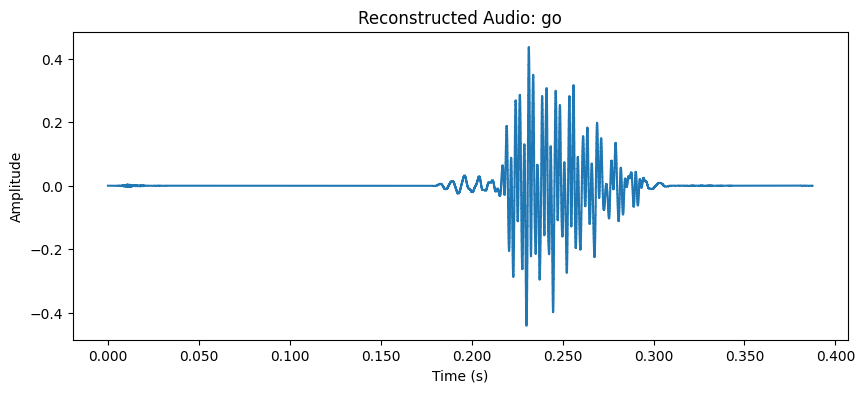

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio

label_map = {0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight',
             6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left',
             12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one',
             18: 'right', 19: 'seven', 20: 'sheila', 21: 'six', 22: 'stop',
             23: 'three', 24: 'tree', 25: 'two', 26: 'up', 27: 'wow', 28: 'yes', 29: 'zero'}
HOP_LENGTH = N_FFT // 2 
# Loop through the batches
for batch in train_loader:
    audio, labels = batch
    
    # Extract the first sample
    mel_spectrogram = audio[0].numpy()  # Convert tensor to numpy
    label_idx = labels[0].item()  # Get the label index
    class_name = label_map[label_idx]  # Map to class name

    
    mel_power = librosa.db_to_power(mel_spectrogram)

    
    mel_to_linear = librosa.feature.inverse.mel_to_stft(
        mel_power, sr=SAMPLE_RATE, n_fft=N_FFT, power=1.0
    )

   
    waveform = librosa.griffinlim(mel_to_linear, hop_length=HOP_LENGTH, win_length=N_FFT)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f"Reconstructed Audio: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Play the reconstructed audio
    display(Audio(waveform, rate=SAMPLE_RATE))

    break 

In [3]:
for batch in train_loader:
    audios, labels = batch
    print(audios.shape) # (batch_size, mel_bins, time_step)
    print(audios[0].shape)
    print(audios[0])
    print(labels[0].shape)
    print(labels[0])
    break

torch.Size([64, 1, 128, 32])
torch.Size([1, 128, 32])
tensor([[[-0.3525, -0.3251, -0.2967,  ...,  0.5025,  0.4529,  0.4210],
         [-0.3226, -0.2337, -0.2053,  ...,  0.5939,  0.5442,  0.5124],
         [-0.3525, -0.3525, -0.3525,  ...,  0.1851, -0.0130, -0.0478],
         ...,
         [-0.3525, -0.3112, -0.0783,  ..., -0.3525, -0.3525, -0.3525],
         [-0.3525, -0.3525, -0.3525,  ..., -0.3525, -0.3525, -0.3525],
         [-0.3525, -0.3525, -0.3525,  ..., -0.3525, -0.3525, -0.3525]]])
torch.Size([])
tensor(7)


In [6]:
import torch
import torch.nn as nn
from tqdm import tqdm

class AudioTransformer(nn.Module):
    def __init__(self, num_classes, input_dim=128, time_steps=32, dim=256, depth=4, heads=4, mlp_dim=512, dropout=0.1):
        super(AudioTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, dim)  
        #self.pos_embedding = nn.Parameter(torch.randn(1, time_steps, dim))  
        self.pos_embedding = nn.Parameter(torch.randn(1, time_steps + 1, dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))  # Class token
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        # x: (B, 128, 32) -> transpose to (B, 32, 128)
        #x = x.unsqueeze(1)
        x = x.permute(0, 2, 1)
        x = oself.embedding(x)  # (B, 32, dim)

        B, T, D = x.size()
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1+T, D)
        x = x + self.pos_embedding[:, :x.size(1), :]  # Add position encoding
       
        

        x = self.transformer_encoder(x)  # (B, T+1, D)
        x = x[:, 0]  # Extract CLS token output

        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = len(label_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioTransformer(num_classes=num_classes).to(device)
print(model)

AudioTransformer(
  (embedding): Linear(in_features=128, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=30, bias=True)
)


In [31]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=(16, 4), embed_dim=64):
        super(PatchEmbedding, self).__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                            
        x = x.flatten(2).transpose(1, 2)             
        return x

class AudioViT(nn.Module):
    def __init__(self, num_classes, embed_dim=64, num_heads=2, depth=4, patch_size=(16, 4)):
        super(AudioViT, self).__init__()

        self.patch_embed = PatchEmbedding(in_channels=1, patch_size=patch_size, embed_dim=embed_dim)
        num_patches = (128 // patch_size[0]) * (32 // patch_size[1])

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)                          # (B, 1, 128, 32)
        x = self.patch_embed(x)                     
        B, N, _ = x.shape

        cls_token = self.cls_token.expand(B, -1, -1)        
        x = torch.cat((cls_token, x), dim=1)               
        x = x + self.pos_embed[:, :x.size(1), :]            # add positional embedding

        x = self.transformer(x)
        x = self.norm(x[:, 0])                              # CLS token output
        return self.fc(x)

num_classes = len(label_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioViT(num_classes=len(label_map)).to(device)


In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

class ViTForSpectrogram(nn.Module):
    def __init__(self, *, in_channels=1, num_classes=10, patch_size=(16, 8), dim=256, depth=6, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (128 // patch_size[0]) * (32 // patch_size[1])  # 8 x 4 = 32 patches

        self.patch_embed = nn.Conv2d(
            in_channels,
            dim,
            kernel_size=patch_size,
            stride=patch_size
        )  # Output shape: (B, dim, 8, 4)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.size(0)  # x shape: (B, 1, 128, 32)

        x = self.patch_embed(x)  
        x = x.flatten(2).transpose(1, 2)  

        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1) 
        x = x + self.pos_embed[:, :x.size(1), :]  
        x = self.dropout(x)

        x = self.transformer(x)  
        return self.mlp_head(x[:, 0])  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForSpectrogram(
    in_channels=1,
    num_classes=len(label_map),  
    patch_size=(8, 8),
    dim=512,
    depth=8,
    heads=8,
    mlp_dim=512,
    dropout=0.1
).to(device)


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm


class ViTForSpectrogramSPT(nn.Module):
    def __init__(self, *, in_channels=1, num_classes=10, patch_size=(16, 8), dim=256, depth=6, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (128 // patch_size[0]) * (32 // patch_size[1])

        self.patch_embed = nn.Conv2d(
            in_channels,
            dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.size(0)

        # SPT: Shift input in 4 directions
        shifts = [
            x,  # original
            F.pad(x, (0, 0, 1, 0))[:, :, :-1, :],  # shift down
            F.pad(x, (0, 0, 0, 1))[:, :, 1:, :],  # shift up
            F.pad(x, (1, 0, 0, 0))[:, :, :, :-1],  # shift right
            F.pad(x, (0, 1, 0, 0))[:, :, :, 1:],  # shift left
        ]

        
        embeddings = [self.patch_embed(s) for s in shifts]
        x = sum(embeddings) / len(embeddings)  

        x = x.flatten(2).transpose(1, 2) 

        cls_tokens = self.cls_token.expand(B, -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1)  
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x)

        x = self.transformer(x)
        return self.mlp_head(x[:, 0])

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForSpectrogramSPT(
    in_channels=1,
    num_classes=len(label_map),
    patch_size=(16, 8),
    dim=256,
    depth=8,
    heads=8,
    mlp_dim=512,
    dropout=0.1
).to(device)


In [29]:
class PatchToClusterAttention(nn.Module):
    def __init__(self, dim, num_clusters=8):
        super().__init__()
        self.num_clusters = num_clusters
        self.cluster_tokens = nn.Parameter(torch.randn(1, num_clusters, dim))
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # x: (B, N, dim) — patch tokens
        B = x.size(0)
        clusters = self.cluster_tokens.expand(B, -1, -1) 
        attn_output, _ = self.attn(x, clusters, clusters)  
        x = self.norm(x + attn_output) 
        return x


class ViTForSpectrogram(nn.Module):
    def __init__(self, *, in_channels=1, num_classes=10, patch_size=(16, 8), dim=256, depth=6, heads=8, mlp_dim=512, dropout=0.1, use_paca=True):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (128 // patch_size[0]) * (32 // patch_size[1])

        self.patch_embed = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.use_paca = use_paca
        if use_paca:
            self.paca = PatchToClusterAttention(dim=dim, num_clusters=8)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  
        x = x.flatten(2).transpose(1, 2)  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x)

        if self.use_paca:
            x = self.paca(x[:, 1:])  
            x = torch.cat((cls_tokens, x), dim=1)  

        x = self.transformer(x)
        return self.mlp_head(x[:, 0])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForSpectrogram(
    in_channels=1,
    num_classes=len(label_map),
    patch_size=(8, 8),
    dim=256,
    depth=8,
    heads=8,
    mlp_dim=512,
    dropout=0.1
).to(device)



In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class ViTForSpectrogramWithRandomPatches(nn.Module):
    def __init__(self, *, in_channels=1, num_classes=10, patch_size=(8, 8), dim=512, depth=8, heads=8, mlp_dim=512, dropout=0.1, image_size=(128, 32), num_random_patches=32):
        super().__init__()

        self.patch_size = patch_size
        self.dim = dim
        self.num_random_patches = num_random_patches
        self.image_size = image_size
        self.in_channels = in_channels

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_random_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def extract_random_patches(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size
        patches = []

        for b in range(B):
            img_patches = []
            for _ in range(self.num_random_patches):
                top = random.randint(0, H - ph)
                left = random.randint(0, W - pw)
                patch = x[b:b+1, :, top:top+ph, left:left+pw]  
                patch = patch.reshape(C, -1)  
                patch = patch.mean(dim=1).unsqueeze(0)  
                patch = F.pad(patch, (0, self.dim - C), mode='constant', value=0)  
                img_patches.append(patch)
            patches.append(torch.cat(img_patches, dim=0).unsqueeze(0))

        return torch.cat(patches, dim=0)  

    def forward(self, x):
        B = x.size(0)  # x shape: (B, 1, 128, 32)

        x = self.extract_random_patches(x) 

        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1)  
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x)

        x = self.transformer(x)
        return self.mlp_head(x[:, 0]) 


# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForSpectrogramWithRandomPatches(
    in_channels=1,
    num_classes=len(label_map),
    patch_size=(8, 8),
    dim=512,
    depth=8,
    heads=8,
    mlp_dim=512,
    dropout=0.1
).to(device)
print(model)


ViTForSpectrogramWithRandomPatches(
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=512, out_features=30, bias=True)
  )
)


In [22]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            #inputs = (inputs - inputs.mean(dim=(1, 2), keepdim=True)) / (inputs.std(dim=(1, 2), keepdim=True) + 1e-6)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
 
            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 10
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/10: 100%|██████████| 643/643 [00:45<00:00, 14.03it/s, accuracy=3.28, loss=3.37]


Epoch 1: Loss = 3.4230, Accuracy = 3.28%


Epoch 2/10: 100%|██████████| 643/643 [00:45<00:00, 14.15it/s, accuracy=12.3, loss=2.43]


Epoch 2: Loss = 3.0200, Accuracy = 12.29%


Epoch 3/10: 100%|██████████| 643/643 [00:45<00:00, 14.12it/s, accuracy=36.7, loss=1.81]


Epoch 3: Loss = 2.1077, Accuracy = 36.72%


Epoch 4/10: 100%|██████████| 643/643 [00:45<00:00, 14.15it/s, accuracy=49.1, loss=1.43]


Epoch 4: Loss = 1.6824, Accuracy = 49.07%


Epoch 5/10: 100%|██████████| 643/643 [00:45<00:00, 14.19it/s, accuracy=56.6, loss=1.33] 


Epoch 5: Loss = 1.4190, Accuracy = 56.64%


Epoch 6/10: 100%|██████████| 643/643 [00:45<00:00, 14.13it/s, accuracy=61, loss=0.988]  


Epoch 6: Loss = 1.2713, Accuracy = 60.99%


Epoch 7/10: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=65, loss=1.54]   


Epoch 7: Loss = 1.1442, Accuracy = 65.04%


Epoch 8/10: 100%|██████████| 643/643 [00:45<00:00, 14.03it/s, accuracy=67.5, loss=1.1]  


Epoch 8: Loss = 1.0548, Accuracy = 67.47%


Epoch 9/10: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=69.5, loss=1.23] 


Epoch 9: Loss = 0.9934, Accuracy = 69.47%


Epoch 10/10: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=71, loss=0.668]  

Epoch 10: Loss = 0.9388, Accuracy = 71.03%


In [9]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            #inputs = (inputs - inputs.mean(dim=(1, 2), keepdim=True)) / (inputs.std(dim=(1, 2), keepdim=True) + 1e-6)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
 
            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 35
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/35: 100%|██████████| 643/643 [00:46<00:00, 13.79it/s, accuracy=72.3, loss=1.58] 


Epoch 1: Loss = 0.8875, Accuracy = 72.28%


Epoch 2/35: 100%|██████████| 643/643 [00:46<00:00, 13.84it/s, accuracy=74, loss=1.19]   


Epoch 2: Loss = 0.8387, Accuracy = 74.04%


Epoch 3/35: 100%|██████████| 643/643 [00:46<00:00, 13.86it/s, accuracy=74.7, loss=1.08] 


Epoch 3: Loss = 0.8019, Accuracy = 74.71%


Epoch 4/35: 100%|██████████| 643/643 [00:46<00:00, 13.83it/s, accuracy=75.7, loss=0.917]


Epoch 4: Loss = 0.7734, Accuracy = 75.68%


Epoch 5/35: 100%|██████████| 643/643 [00:46<00:00, 13.82it/s, accuracy=76.6, loss=0.186]


Epoch 5: Loss = 0.7452, Accuracy = 76.57%


Epoch 6/35: 100%|██████████| 643/643 [00:46<00:00, 13.83it/s, accuracy=77.5, loss=0.776]


Epoch 6: Loss = 0.7182, Accuracy = 77.52%


Epoch 7/35: 100%|██████████| 643/643 [00:46<00:00, 13.87it/s, accuracy=78, loss=0.625]  


Epoch 7: Loss = 0.6949, Accuracy = 77.99%


Epoch 8/35: 100%|██████████| 643/643 [00:46<00:00, 13.91it/s, accuracy=79, loss=0.855]  


Epoch 8: Loss = 0.6647, Accuracy = 78.97%


Epoch 9/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=79.5, loss=0.961]


Epoch 9: Loss = 0.6430, Accuracy = 79.51%


Epoch 10/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=80.3, loss=0.34] 


Epoch 10: Loss = 0.6246, Accuracy = 80.27%


Epoch 11/35: 100%|██████████| 643/643 [00:46<00:00, 13.93it/s, accuracy=80.7, loss=0.512]


Epoch 11: Loss = 0.6104, Accuracy = 80.73%


Epoch 12/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=81.3, loss=0.422]


Epoch 12: Loss = 0.5907, Accuracy = 81.25%


Epoch 13/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=81.9, loss=0.77] 


Epoch 13: Loss = 0.5702, Accuracy = 81.86%


Epoch 14/35: 100%|██████████| 643/643 [00:46<00:00, 13.91it/s, accuracy=82.1, loss=0.743]


Epoch 14: Loss = 0.5617, Accuracy = 82.11%


Epoch 15/35: 100%|██████████| 643/643 [00:46<00:00, 13.95it/s, accuracy=82.7, loss=0.592]


Epoch 15: Loss = 0.5395, Accuracy = 82.74%


Epoch 16/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=83.1, loss=0.538]


Epoch 16: Loss = 0.5266, Accuracy = 83.12%


Epoch 17/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=83.6, loss=0.384]


Epoch 17: Loss = 0.5148, Accuracy = 83.64%


Epoch 18/35: 100%|██████████| 643/643 [00:46<00:00, 13.80it/s, accuracy=83.9, loss=0.378]


Epoch 18: Loss = 0.5054, Accuracy = 83.86%


Epoch 19/35: 100%|██████████| 643/643 [00:46<00:00, 13.88it/s, accuracy=84.1, loss=0.866]


Epoch 19: Loss = 0.4953, Accuracy = 84.10%


Epoch 20/35: 100%|██████████| 643/643 [00:46<00:00, 13.85it/s, accuracy=84.3, loss=0.327]


Epoch 20: Loss = 0.4864, Accuracy = 84.29%


Epoch 21/35: 100%|██████████| 643/643 [00:46<00:00, 13.88it/s, accuracy=84.8, loss=0.429]


Epoch 21: Loss = 0.4738, Accuracy = 84.79%


Epoch 22/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=85.2, loss=0.19] 


Epoch 22: Loss = 0.4589, Accuracy = 85.25%


Epoch 23/35: 100%|██████████| 643/643 [00:46<00:00, 13.90it/s, accuracy=85.2, loss=0.368]


Epoch 23: Loss = 0.4532, Accuracy = 85.24%


Epoch 24/35: 100%|██████████| 643/643 [00:46<00:00, 13.90it/s, accuracy=85.6, loss=0.51] 


Epoch 24: Loss = 0.4461, Accuracy = 85.61%


Epoch 25/35: 100%|██████████| 643/643 [00:46<00:00, 13.92it/s, accuracy=85.8, loss=0.212]


Epoch 25: Loss = 0.4375, Accuracy = 85.80%


Epoch 26/35: 100%|██████████| 643/643 [00:45<00:00, 13.98it/s, accuracy=86.2, loss=0.715]


Epoch 26: Loss = 0.4280, Accuracy = 86.23%


Epoch 27/35: 100%|██████████| 643/643 [00:45<00:00, 13.98it/s, accuracy=86.4, loss=0.334]


Epoch 27: Loss = 0.4211, Accuracy = 86.37%


Epoch 28/35: 100%|██████████| 643/643 [00:45<00:00, 13.98it/s, accuracy=86.6, loss=0.386]


Epoch 28: Loss = 0.4142, Accuracy = 86.61%


Epoch 29/35: 100%|██████████| 643/643 [00:45<00:00, 13.99it/s, accuracy=86.8, loss=0.304]


Epoch 29: Loss = 0.4101, Accuracy = 86.77%


Epoch 30/35: 100%|██████████| 643/643 [00:45<00:00, 13.98it/s, accuracy=87.1, loss=0.309]


Epoch 30: Loss = 0.4022, Accuracy = 87.06%


Epoch 31/35: 100%|██████████| 643/643 [00:45<00:00, 13.99it/s, accuracy=87.2, loss=0.354]


Epoch 31: Loss = 0.3940, Accuracy = 87.21%


Epoch 32/35: 100%|██████████| 643/643 [00:45<00:00, 14.01it/s, accuracy=87.4, loss=0.47]  


Epoch 32: Loss = 0.3864, Accuracy = 87.44%


Epoch 33/35: 100%|██████████| 643/643 [00:45<00:00, 13.98it/s, accuracy=87.4, loss=0.503]


Epoch 33: Loss = 0.3823, Accuracy = 87.42%


Epoch 34/35: 100%|██████████| 643/643 [00:46<00:00, 13.97it/s, accuracy=87.8, loss=0.383]


Epoch 34: Loss = 0.3727, Accuracy = 87.80%


Epoch 35/35: 100%|██████████| 643/643 [00:46<00:00, 13.91it/s, accuracy=88.1, loss=0.486] 

Epoch 35: Loss = 0.3650, Accuracy = 88.05%


In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            #inputs = (inputs - inputs.mean(dim=(1, 2), keepdim=True)) / (inputs.std(dim=(1, 2), keepdim=True) + 1e-6)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
 
            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the model
num_epochs = 50
train(model, train_loader, criterion, optimizer, device, num_epochs)


Epoch 1/50: 100%|██████████| 643/643 [00:45<00:00, 14.12it/s, accuracy=88.5, loss=0.435] 


Epoch 1: Loss = 0.3570, Accuracy = 88.52%


Epoch 2/50: 100%|██████████| 643/643 [00:45<00:00, 14.21it/s, accuracy=88.5, loss=0.353] 


Epoch 2: Loss = 0.3564, Accuracy = 88.45%


Epoch 3/50: 100%|██████████| 643/643 [00:45<00:00, 14.13it/s, accuracy=88.4, loss=0.6]  


Epoch 3: Loss = 0.3542, Accuracy = 88.42%


Epoch 4/50: 100%|██████████| 643/643 [00:45<00:00, 14.16it/s, accuracy=88.7, loss=0.227]


Epoch 4: Loss = 0.3499, Accuracy = 88.69%


Epoch 5/50: 100%|██████████| 643/643 [00:45<00:00, 14.19it/s, accuracy=88.9, loss=0.147] 


Epoch 5: Loss = 0.3395, Accuracy = 88.93%


Epoch 6/50: 100%|██████████| 643/643 [00:45<00:00, 14.16it/s, accuracy=89.1, loss=0.0435]


Epoch 6: Loss = 0.3314, Accuracy = 89.12%


Epoch 7/50: 100%|██████████| 643/643 [00:46<00:00, 13.95it/s, accuracy=89.2, loss=0.204]


Epoch 7: Loss = 0.3274, Accuracy = 89.18%


Epoch 8/50: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=89.6, loss=0.0471]


Epoch 8: Loss = 0.3174, Accuracy = 89.64%


Epoch 9/50: 100%|██████████| 643/643 [00:45<00:00, 14.03it/s, accuracy=89.7, loss=0.259] 


Epoch 9: Loss = 0.3188, Accuracy = 89.66%


Epoch 10/50: 100%|██████████| 643/643 [00:45<00:00, 14.09it/s, accuracy=89.7, loss=0.257] 


Epoch 10: Loss = 0.3126, Accuracy = 89.75%


Epoch 11/50: 100%|██████████| 643/643 [00:45<00:00, 14.10it/s, accuracy=89.8, loss=0.278] 


Epoch 11: Loss = 0.3084, Accuracy = 89.84%


Epoch 12/50: 100%|██████████| 643/643 [00:45<00:00, 13.98it/s, accuracy=89.6, loss=0.89]  


Epoch 12: Loss = 0.3173, Accuracy = 89.62%


Epoch 13/50: 100%|██████████| 643/643 [00:45<00:00, 13.99it/s, accuracy=89.8, loss=0.0663]


Epoch 13: Loss = 0.3082, Accuracy = 89.82%


Epoch 14/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=90.1, loss=0.248] 


Epoch 14: Loss = 0.2975, Accuracy = 90.15%


Epoch 15/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=90.3, loss=0.402] 


Epoch 15: Loss = 0.2968, Accuracy = 90.33%


Epoch 16/50: 100%|██████████| 643/643 [00:45<00:00, 14.08it/s, accuracy=90.4, loss=0.356]


Epoch 16: Loss = 0.2941, Accuracy = 90.44%


Epoch 17/50: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=90.8, loss=0.512] 


Epoch 17: Loss = 0.2855, Accuracy = 90.79%


Epoch 18/50: 100%|██████████| 643/643 [00:45<00:00, 14.11it/s, accuracy=90.7, loss=0.158] 


Epoch 18: Loss = 0.2804, Accuracy = 90.65%


Epoch 19/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=90.7, loss=0.445] 


Epoch 19: Loss = 0.2818, Accuracy = 90.72%


Epoch 20/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=90.7, loss=0.73]  


Epoch 20: Loss = 0.2828, Accuracy = 90.70%


Epoch 21/50: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=90.7, loss=0.0945]


Epoch 21: Loss = 0.2772, Accuracy = 90.74%


Epoch 22/50: 100%|██████████| 643/643 [00:45<00:00, 14.00it/s, accuracy=91.2, loss=0.186] 


Epoch 22: Loss = 0.2664, Accuracy = 91.24%


Epoch 23/50: 100%|██████████| 643/643 [00:45<00:00, 14.02it/s, accuracy=91.2, loss=0.296] 


Epoch 23: Loss = 0.2676, Accuracy = 91.25%


Epoch 24/50: 100%|██████████| 643/643 [00:45<00:00, 14.04it/s, accuracy=91.5, loss=0.287] 


Epoch 24: Loss = 0.2573, Accuracy = 91.47%


Epoch 25/50: 100%|██████████| 643/643 [00:45<00:00, 14.09it/s, accuracy=91.4, loss=0.308] 


Epoch 25: Loss = 0.2650, Accuracy = 91.42%


Epoch 26/50: 100%|██████████| 643/643 [00:45<00:00, 14.04it/s, accuracy=91.5, loss=0.155] 


Epoch 26: Loss = 0.2603, Accuracy = 91.45%


Epoch 27/50: 100%|██████████| 643/643 [00:45<00:00, 14.09it/s, accuracy=91.7, loss=0.116] 


Epoch 27: Loss = 0.2486, Accuracy = 91.69%


Epoch 28/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=91.6, loss=0.282] 


Epoch 28: Loss = 0.2547, Accuracy = 91.59%


Epoch 29/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=91.7, loss=0.301] 


Epoch 29: Loss = 0.2516, Accuracy = 91.67%


Epoch 30/50: 100%|██████████| 643/643 [00:45<00:00, 14.14it/s, accuracy=91.9, loss=0.191] 


Epoch 30: Loss = 0.2480, Accuracy = 91.87%


Epoch 31/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=92, loss=0.0977]  


Epoch 31: Loss = 0.2423, Accuracy = 92.04%


Epoch 32/50: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=91.8, loss=0.297] 


Epoch 32: Loss = 0.2462, Accuracy = 91.82%


Epoch 33/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=92, loss=0.0994]  


Epoch 33: Loss = 0.2446, Accuracy = 91.98%


Epoch 34/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=92.2, loss=0.714] 


Epoch 34: Loss = 0.2398, Accuracy = 92.19%


Epoch 35/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=92.4, loss=0.16]  


Epoch 35: Loss = 0.2298, Accuracy = 92.45%


Epoch 36/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=92.3, loss=0.0315]


Epoch 36: Loss = 0.2330, Accuracy = 92.27%


Epoch 37/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=92.3, loss=0.114] 


Epoch 37: Loss = 0.2319, Accuracy = 92.33%


Epoch 38/50: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=92.4, loss=0.408] 


Epoch 38: Loss = 0.2278, Accuracy = 92.43%


Epoch 39/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=92.4, loss=0.285] 


Epoch 39: Loss = 0.2292, Accuracy = 92.35%


Epoch 40/50: 100%|██████████| 643/643 [00:45<00:00, 14.07it/s, accuracy=92.4, loss=0.139] 


Epoch 40: Loss = 0.2296, Accuracy = 92.39%


Epoch 41/50: 100%|██████████| 643/643 [00:46<00:00, 13.96it/s, accuracy=92.6, loss=0.161] 


Epoch 41: Loss = 0.2248, Accuracy = 92.55%


Epoch 42/50: 100%|██████████| 643/643 [00:45<00:00, 14.04it/s, accuracy=92.8, loss=0.152] 


Epoch 42: Loss = 0.2207, Accuracy = 92.85%


Epoch 43/50: 100%|██████████| 643/643 [00:45<00:00, 14.02it/s, accuracy=92.7, loss=0.268] 


Epoch 43: Loss = 0.2214, Accuracy = 92.65%


Epoch 44/50: 100%|██████████| 643/643 [00:45<00:00, 14.06it/s, accuracy=92.6, loss=0.0188]


Epoch 44: Loss = 0.2211, Accuracy = 92.64%


Epoch 45/50: 100%|██████████| 643/643 [00:45<00:00, 14.08it/s, accuracy=92.9, loss=0.177] 


Epoch 45: Loss = 0.2161, Accuracy = 92.87%


Epoch 46/50: 100%|██████████| 643/643 [00:45<00:00, 14.04it/s, accuracy=93, loss=0.296]   


Epoch 46: Loss = 0.2114, Accuracy = 93.03%


Epoch 47/50: 100%|██████████| 643/643 [00:45<00:00, 14.08it/s, accuracy=92.9, loss=0.27]  


Epoch 47: Loss = 0.2162, Accuracy = 92.95%


Epoch 48/50: 100%|██████████| 643/643 [00:45<00:00, 14.11it/s, accuracy=92.9, loss=0.115] 


Epoch 48: Loss = 0.2095, Accuracy = 92.89%


Epoch 49/50: 100%|██████████| 643/643 [00:45<00:00, 14.10it/s, accuracy=93.2, loss=0.0178]


Epoch 49: Loss = 0.2082, Accuracy = 93.16%


Epoch 50/50: 100%|██████████| 643/643 [00:45<00:00, 14.05it/s, accuracy=93.1, loss=0.214] 

Epoch 50: Loss = 0.2058, Accuracy = 93.11%


In [28]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Evaluating", leave=True)

    for batch in loop:
        inputs, labels = batch
        #inputs = (inputs - inputs.mean(dim=(1, 2), keepdim=True)) / (inputs.std(dim=(1, 2), keepdim=True) + 1e-6)
        inputs, labels = inputs.to(device), labels.to(device)

        # Transpose inputs for transformer
        #inputs = inputs.transpose(1, 2)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

evaluate(model, test_loader, criterion, device)

Evaluating: 100%|██████████| 161/161 [00:02<00:00, 62.34it/s, accuracy=91.8, loss=0.294] 

Validation Loss: 0.2956, Accuracy: 91.84%


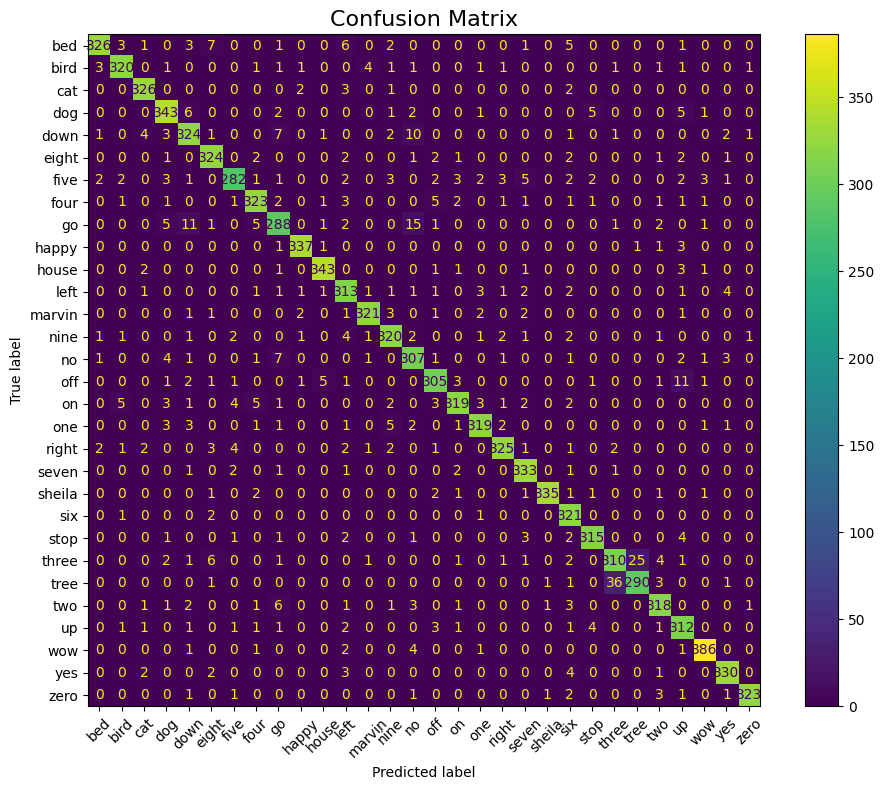

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_and_confusion_matrix(model, test_loader, device, label_map):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    display_labels = list(label_map.keys())

    fig, ax = plt.subplots(figsize=(10, 8))  # ← Increased size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(xticks_rotation=45, cmap='viridis', values_format='d', ax=ax)
    
    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

evaluate_and_confusion_matrix(model, test_loader, device, label_map)